**Fibonacci Pattern:** 

bullish pattern signal:  
current_close time +8  
close_8d < close_5d   
close_8d < close_3d  
close_8d < close_2d  

bearish pattern:  
current_close time +8  
close_8d > close_5d   
close_8d > close_3d  
close_8d > close_2d  


bullish 无效当 next close <= busilish pattern signal  
bearish 无效当 next close >= bearish pattern signal  


Bollinger Bands:  
buy signal: stock > lower bander  
sell signal: stock < upper bander  

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ticker = 'AAPL'
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'
fh_key = 'bt3efpf48v6tfcs816eg'
stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from=2021-01-01&to=2021-07-27&apikey={fm_key}').json()
stock = pd.DataFrame(stock['historical'])
stock['date'] = pd.to_datetime(stock['date'])

In [3]:
# stock moving average
def MA(tp, n):
    ma = tp.rolling(window = n).mean()
    return ma

# bounds
def Bounds(tp, sma, n, m):
    std = tp.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands

In [4]:
# stock['sig'] = np.nan # bullish or bearish signal
stock['pos'] = np.nan # position for next day
ts = 0 # trading signal
entry = [] # long
exit = [] # short
for d in range(7,len(stock)-1):
    # bullish signal
    if (stock.loc[d,'close'] < stock.loc[d-3,'close'] < stock.loc[d-5,'close'] < stock.loc[d-6,'close'])\
    & (stock.loc[d+1,'close'] > stock.loc[d,'close']): # compare with next day close price to confirm signal
        #stock.loc[d,'sig'] = 'bullish'
        if stock.loc[d+1, 'close'] > stock.loc[d+1, 'BOLD']: # Bollinger band
            if ts != 1:
                entry.append(stock.loc[d+1,'date'])
            ts = 1

    elif (stock.loc[d,'close'] > stock.loc[d-3,'close'] > stock.loc[d-5,'close'] > stock.loc[d-6,'close'])\
    & (stock.loc[d+1,'close'] < stock.loc[d,'close']): # compare with next day close price to confirm signal
        #stock.loc[d, 'sig'] = 'bearish'
        if stock.loc[d+1, 'close'] < stock.loc[d+1, 'BOLU']: # Bollinger band
            if ts != -1:
                exit.append(stock.loc[d+1,'date'])
            ts = -1
        
    stock.loc[d+1,'pos'] = ts

In [7]:
stock = stock.set_index('date')

In [8]:
stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

stock['rtn'] = stock['close'].pct_change()
stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

stock = stock.dropna()

# stock['rtn'] = np.log(stock.close.div(stock.close.shift(1)))
# stock['srtn'] = stock.pos.shift(1) * stock.rtn
# stock['crtn'] = stock['rtn'].cumsum().apply(np.exp) # without strategy
# stock['crtn_s'] = stock['srtn'].cumsum().apply(np.exp) # with strategy
# stock = stock.dropna()

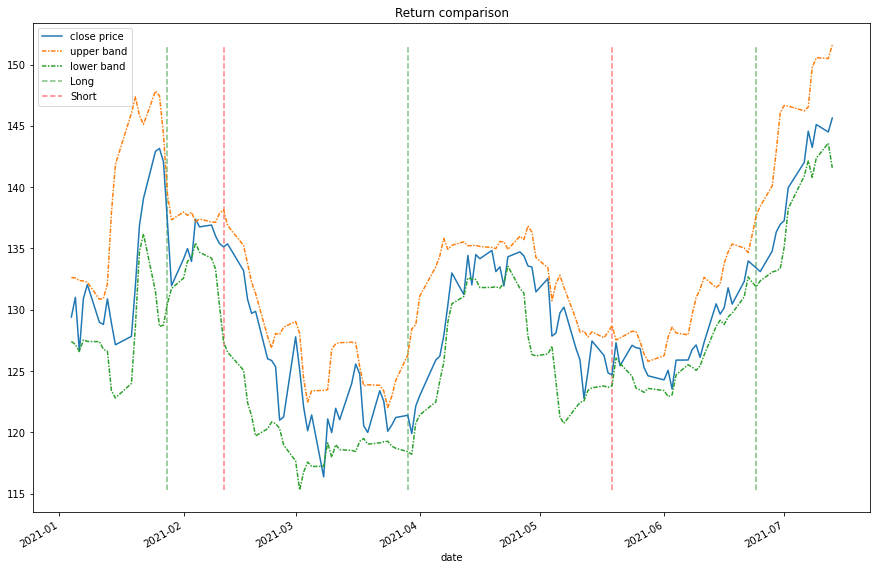

In [13]:
fig, ax = plt.subplots(figsize = (15, 10))
stock['close'].plot(label = 'close price', ax = ax)
stock['BOLU'].plot(label = 'upper band', linestyle = (0, (3, 1, 1, 1)), ax = ax)
stock['BOLD'].plot(label = 'lower band', linestyle = (0, (3, 1, 1, 1)), ax = ax)
ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD))
ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD))
ax.vlines(entry, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 0.5)
ax.vlines(exit, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 0.5)
plt.legend()
plt.title(f'{ticker}')
plt.show()

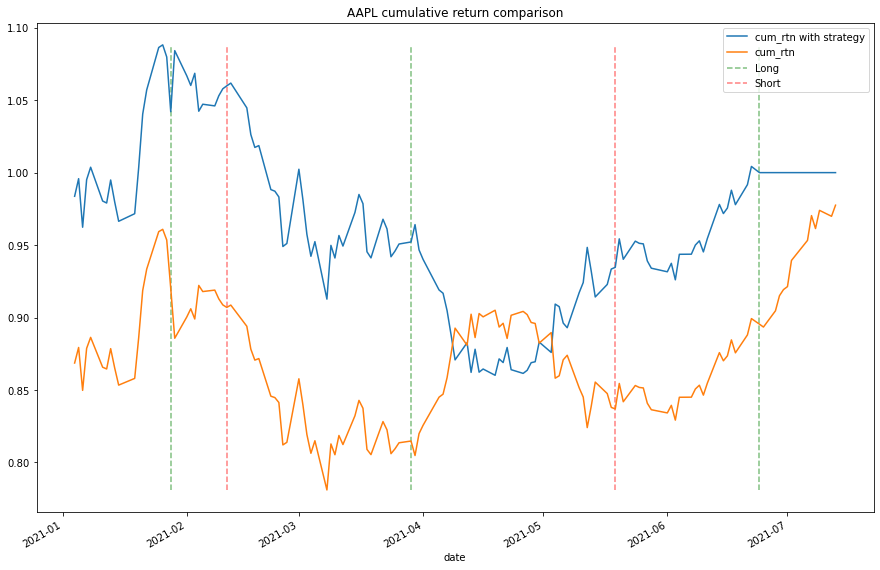

In [14]:
fig, ax = plt.subplots(figsize = (15, 10))
stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = ax)
stock['cum_rtn'].plot(label = 'cum_rtn', ax = ax)
ymin = min(min(stock.cum_rtn_s), min(stock.cum_rtn))
ymax = max(max(stock.cum_rtn_s), max(stock.cum_rtn))
ax.vlines(entry, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 0.5)
ax.vlines(exit, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 0.5)
plt.legend()
plt.title(f'{ticker} cumulative return comparison')
plt.show()

In [ ]:
# stock.head(30)

In [ ]:
# import mplfinance as fplt

# stock['date'] = pd.to_datetime(stock['date'], unit = 'D')
# fplt.plot(stock.set_index('date'), type = 'candle', title = f'{ticker} stock price', ylabel = 'price')